In [1]:
import rebound
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pymc3 as pm
import scipy
from scipy.integrate import quad
from itertools import cycle

plt.style.use('paper.mplstyle')
%matplotlib inline

df = pd.read_csv('../csvs/Kepler-23_stability.csv', index_col=0)
df.tail()

,sim,Mstar,Z12,Z23,mu1,mu2,mu3,e1,e2,e3,...,h3,k1,k2,k3,ecom,ejection,t_instability,nbodystable,crossing,spockprob
27048,1999380.0,0.880613,0.201456,0.102933,2.729311e-06,0.000012,0.000003,0.198727,0.155031,0.014555,...,0.013028,-0.172274,0.117442,0.006489,0.101288,False,5.358731e+04,False,True,0.010296
27049,1999466.0,1.214257,0.028857,0.021840,8.367568e-07,0.000042,0.000007,0.039781,0.010983,0.022669,...,-0.022128,-0.000577,-0.010441,0.004925,0.008076,False,1.000000e+09,True,False,0.787886
27050,1999693.0,1.225737,0.075364,0.066737,9.338099e-06,0.000078,0.000004,0.088874,0.108052,0.175515,...,-0.001799,-0.037102,-0.107794,-0.175506,0.104393,False,6.319852e+04,False,False,0.009134
27051,1999943.0,1.083352,0.130137,0.077125,1.474248e-06,0.000006,0.000018,0.224166,0.236365,0.140135,...,0.055326,0.024470,-0.146544,-0.128751,0.156694,False,2.133985e+04,False,False,0.005355
27052,1999969.0,1.159434,0.045962,0.052065,3.549245e-06,0.000037,0.000085,0.095140,0.020418,0.050637,...,0.047178,-0.075962,-0.010202,0.018394,0.026185,False,6.663452e+04,False,False,0.014513


# Make each bin have the same amount of total SPOCK probability so each one contributes equally to final posterior

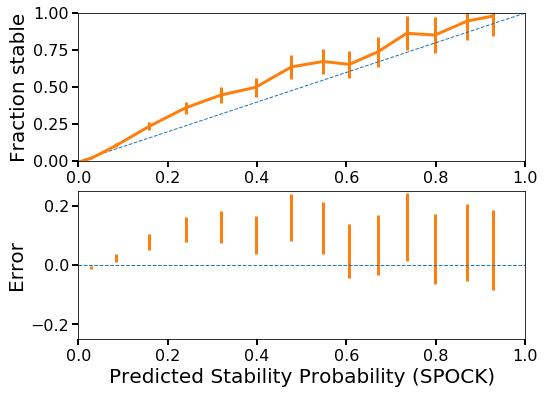

In [2]:
Nbins = 15

dfc = df.iloc[10000:]
sortedpreds = dfc[(dfc['crossing'] == False) & (dfc['spockprob']>0)]['spockprob'].sort_values()
testy = dfc[(dfc['crossing'] == False) & (dfc['spockprob']>0)]['nbodystable']==1

cdf = np.cumsum(sortedpreds)/sortedpreds.sum()
edges = np.linspace(0,1,Nbins+1)
idx = np.searchsorted(cdf, edges)
probedges = sortedpreds.iloc[idx].values

hist, edges = np.histogram(sortedpreds, bins=probedges)
bincenters = np.array([sortedpreds.iloc[idx[i]:idx[i+1]].median() for i in range(len(idx)-1)])

fracstable = []
errorbars = []
for i in range(len(edges)-1):
    mask = (sortedpreds >= edges[i]) & (sortedpreds < edges[i+1])
    nstable = testy[mask].sum()
    fracstable.append(nstable/hist[i]) # fraction of stable systems in bin with predictions in range
    errorbars.append(np.sqrt(nstable)/hist[i]) # 

fig, ax = plt.subplots(nrows=2, figsize=(8,6))
ax[0].plot(np.linspace(0,1,100), np.linspace(0,1,100), '--', lw=1)
ax[0].errorbar(bincenters, fracstable, errorbars)
ax[0].set_xlim([0,1])
ax[0].set_ylim([0,1])
ax[0].set_ylabel('Fraction stable')

ax[1].plot(np.linspace(0,1,100), np.zeros(100), '--', lw=1)
ax[1].errorbar(bincenters, fracstable-bincenters, errorbars, linestyle='')
ax[1].set_ylim([-0.25,0.25])
ax[1].set_xlabel('Predicted Stability Probability (SPOCK)')
ax[1].set_ylabel('Error')
ax[1].set_xlim([0,1])

fig.savefig('spockperformance.pdf', bbox_inches='tight')

Fraction with SPOCK prob < 0.1:

In [3]:
preds = dfc[(dfc['crossing'] == False) & (dfc['spockprob']>0)]['spockprob']
(preds < 0.1).sum()/preds.shape[0]

0.8380168821455284